In [57]:
# Import the necessary packages
from IPython.display import Markdown
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from supreme_court_predictions.summary_analysis.descriptive_statistics import (
    DescriptiveStatistics,
)
from supreme_court_predictions.models.logistic_regression import (
    LogisticRegression,
)
from supreme_court_predictions.models.random_forest import RandomForest
from supreme_court_predictions.models.xg_boost import XGBoost
from supreme_court_predictions.util.functions import get_full_data_pathway

%load_ext jupyter_black
%matplotlib inline

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [58]:
# Setup - Datasets
LABELS = np.array(["for respondent", "for petitioner"])

# Loading unprocessed dataframes
data_path = get_full_data_pathway("clean_convokit/")
utterances = pd.read_csv(data_path + "utterances_df.csv")
advocates = pd.read_csv(data_path + "advocates_df.csv")
cases = pd.read_csv(data_path + "cases_df.csv")
conversations = pd.read_csv(data_path + "conversations_df.csv")
speakers = pd.read_csv(data_path + "speakers_df.csv")
voters = pd.read_csv(data_path + "voters_df.csv")

# Loading processed dataframes
proc_data_path = get_full_data_pathway("processed/")
cases_proc = pd.read_pickle(proc_data_path + "case_aggregations.p")
judges_proc = pd.read_pickle(proc_data_path + "judge_aggregations.p")
adversary_proc = pd.read_pickle(proc_data_path + "adversary_aggregations.p")
advocate_proc = pd.read_pickle(proc_data_path + "advocate_aggregations.p")

# Load descriptive statistics
ds = DescriptiveStatistics()
ds.parse_all_data()

In [59]:
# Setup - Models and plots
# Load models
lr = LogisticRegression()
lr.run()

rf = RandomForest()
rf.run()

xg = XGBoost()
xg.run()

# Model Comparison DF - using advocate utterances
ADVERSARY_AGGS = "adversary_aggregations"
models = [
    "logistic regression",
    "random forest",
    "xg boost",
]
accuracy = [
    lr.accuracies[ADVERSARY_AGGS],
    rf.accuracies[ADVERSARY_AGGS],
    xg.accuracies[ADVERSARY_AGGS],
]
f1 = [
    lr.f1[ADVERSARY_AGGS],
    rf.f1[ADVERSARY_AGGS],
    xg.f1[ADVERSARY_AGGS],
]
execution_time = [
    lr.execution_times[ADVERSARY_AGGS],
    rf.execution_times[ADVERSARY_AGGS],
    xg.execution_times[ADVERSARY_AGGS],
]

model_comp = {
    "model": models,
    "accuracy": accuracy,
    "f1_score": f1,
    "execution_time": execution_time,
}
model_comp = pd.DataFrame.from_dict(model_comp)

In [1]:
# Helper Functions
def dict_to_df(column_names, dict1, dict2=None, dict3=None):
    """
    Transforms a dictionary to a dataframe for better presentation.

    :param column_names (list): List of column names for dataframe.
    :param dict1 (dictionary): Dictionary of data to convert.
    :param dict2 (dictionary, optional): Dictionary of data to convert.
    :param dict3 (dictionary, optional): Dictionary of data to convert.
    : return (DataFrame) DataFrame representation of dictionary.
    """

    df = {
        column_names[0]: list(dict1.keys()),
        column_names[1]: list(dict1.values()),
    }

    if dict2:
        df[column_names[2]] = list(dict2.values())

    if dict3:
        df[column_names[3]] = list(dict2.values())

    df = pd.DataFrame.from_dict(df)

    return df


def disp_accuracy(df, labs, x_label="Dataset"):
    """
    Creates a barchart representing the accuracy and f1 scores of a dataset.

    :param df (DataFrame) Dataframe with three columns: dataset name, accuracy
                          score, and F1 score.
    """
    # Seaborn plots theme
    # sns.set_theme(style="white")

    # set width of bar
    barWidth = 0.25
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()

    # set height of bar
    accs = list(df["accuracy"])
    f1 = list(df["f1_score"])
    execution_time = list(df["execution_time"])

    # Set position of bar on X axis
    br1 = np.arange(len(df))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    ax1.plot(
        plt.bar(
            br1,
            accs,
            color="gray",
            width=barWidth,
            edgecolor="grey",
            label="Accuracy",
        )
    )
    ax1.plot(
        plt.bar(
            br2,
            f1,
            color="blue",
            width=barWidth,
            edgecolor="grey",
            label="F1 Score",
        )
    )
    ax2.plot(
        plt.bar(
            br3,
            execution_time,
            color="red",
            width=barWidth,
            edgecolor="grey",
            label="Execution time",
        )
    )

    # Manage axes
    plt.xlabel(x_label, fontweight="bold", fontsize=15)
    ax1.set_ylabel("Prop Correct Prediction", fontweight="bold", fontsize=15)
    ax2.set_ylabel("Execution Time in Seconds", fontweight="bold", fontsize=15)
    plt.xticks(
        [r + barWidth for r in range(len(accs))],
        labs,
    )
    ax2.set_ylim([0, math.ceil(df["execution_time"].max())])

    plt.legend()
    plt.show()


def disp_conf_matrix(cm):
    """
    Creates a plot of the confusion matrix.

    :param cm (array): Confusion matrix to display.
    """
    # Seaborn plots theme
    sns.set_theme(style="white")

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=LABELS,
    )
    disp.plot()
    plt.show()

### Finetuning Functions

In [61]:
# Value columns for long format
value_cols = [
    "case_aggregations",
    "judge_aggregations",
    "advocate_aggregations",
    "adversary_aggregations",
]


def get_long_df(
    param_name, param_values, accuracy_dicts, f1_dicts, execution_time_dicts
):
    """
    Converts the accuracy dataframes to long format for
    posterior plotting
    """
    # Dataframe of accuracy, f1 scores, and execution times
    acc_df = pd.DataFrame.from_dict(accuracy_dicts)
    f1_df = pd.DataFrame.from_dict(f1_dicts)
    et_df = pd.DataFrame.from_dict(f1_dicts)

    # Add parameter values to dataframe
    acc_df[param_name] = param_values
    f1_df[param_name] = param_values
    et_df[param_name] = param_values

    # Convert to long format
    acc_melted = acc_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )
    f1_melted = f1_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )
    et_melted = et_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )

    return acc_melted, f1_melted, et_melted

In [62]:
def plot_accuracy_scores(
    melted_df, param_name, model_name, accuracy_metric=None
):
    """
    Plots accuracy scores when finetuning a parameter

    Parameters
    ----------
    param_name : str
        Name of parameter being finetuned
    melted_df : pandas dataframe
        Dataframe with accuracy scores in long format
    """

    # Seaborn plots theme
    # sns.set_theme(style="darkgrid")

    fig_dims = (10, 12)
    fig, ax1 = plt.subplots(figsize=fig_dims)
    ax1 = sns.lineplot(
        x=param_name,
        y="value",
        data=melted_df,
        hue="type",
        style="type",
        markers=True,
        dashes=False,
    )
    fig.set_size_inches(12.7, 9.27)
    plt.ticklabel_format(style="plain", axis="y")
    if accuracy_metric is None:
        ax1.set_title(
            f"Accuracy Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel("Accuracy Score", fontsize=16)
    else:
        ax1.set_title(
            f"{accuracy_metric} Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel(f"{accuracy_metric} Score", fontsize=16)

    ax1.set_xlabel(param_name, fontsize=16)
    plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right", borderaxespad=0)

    plt.show()

## Machine Learning Final Presentation
### Predicting Outcomes of US Supreme Court Oral Arguments
**Team Members:** Federico Dominguez, Chanteria Milner, Jessup Jong, and Michael Plunkett

## Background
- <b>Dataset</b>: Supreme Court Oral Arguments Corpus
- <b>Souce</b>: Court transcripts from [oyez.org](https://www.oyez.org/), voting information from [Supreme Court Dataset](http://scdb.wustl.edu/index.php)
- <b>Goal</b>: Predict case decision using case transcripts and NLP models


## Datasets
### Six total datasets
1. Cases
2. Speakers
3. Voters
4. Advocates
5. Conversations
6. Utterances


### Case Information
Includes infromation on each <i>court case</i>, such as:
- Unique case ID
- Year and title of case
- Case petitioner and respondent
- Winning side (1 = for petitioner) and decision date

In [63]:
ds.cases_stats

counts  percentages
win side             for petitioner   284.0    66.510539
                     for respondent   143.0    33.489461
cases                                 427.0          NaN
courts                                  1.0          NaN
years (2014 to 2019)                    6.0          NaN
petitioners                           413.0          NaN
respondents                           356.0          NaN

### Speakers
Includes infromation on each <i>speaker</i>, such as:
- Speaker name and unique speaker key
- Speaker role and type (justice, advocate, nan)

In [64]:
ds.speakers_stats

counts  percentages
speaker type  advocate (A)  8942.0    99.610115
              justice (J)     35.0     0.389885
speaker names               8928.0          NaN
speaker keys                8977.0          NaN

### Voters
Includes infromation on each <i>vote and voter</i>, such as:
- Unique case ID
- Voter key and vote side (judges only, 1=for petitioner)

In [65]:
ds.voters_stats.head(7)

counts percentages
votes    for petitioner        1912.0   60.659898
         for respondent        1240.0   39.340102
justices                         11.0         NaN
justice  j__john_g_roberts_jr     363    0.661157
         j__antonin_scalia         66    0.651515
         j__anthony_m_kennedy     240    0.658333
         j__clarence_thomas       364    0.532967

### Advocates
Includes infromation on each <i>advocate (non-judges)</i>, such as:
- Unique case ID
- Advocate ID and advocacy side(1 = for petitioner)
- Advocate role

In [66]:
ds.advocates_stats

counts  percentages
side            for petitioner   403.0    50.124378
                for respondent   401.0    49.875622
total advocates                  391.0          NaN
total roles                      154.0          NaN
aggregate roles inferred          10.0     1.243781
                for respondent   404.0    50.248756
                for petitioner   390.0    48.507463

### Conversations
Includes infromation on each <i>conversation</i>. There is one conversation per case, <br>
and conversations are made up of individual utterances. Conversation information includes:

- Unique case ID
- Unique conversation ID
- Winning side (1 = for petitioner)

In [67]:
conversations.head(2)

,id,case_id,winning_side
0,23291,2014_13-553,1
1,23252,2014_13-895,1


### Utterances
Includes infromation on each <i>utterance</i>, such as:
- Unique case ID
- Corresponding conversation ID
- Speaker key
- Utterance text

In [68]:
cols = ["case_id", "speaker", "speaker_type", "conversation_id", "text"]
utterances.head(2).loc[:, cols]

,case_id,speaker,speaker_type,conversation_id,text
0,2014_13-553,j__john_g_roberts_jr,J,23291,"we'll hear argument next in case no. 13-553, t..."
1,2014_13-553,andrew_l_brasher,A,23291,"thank you, mr. chief justice, and may it pleas..."


## Data Cleaning and Pre-Processing
### Data Cleaning Steps:
1. Limited cases to those that ruled either for the petitioner or respondent (removed undetermined)
2. Removed cases with no utterances
3. Cleaned utterance text
4. Filtered cases to include last 5 years of dataset (2014-2019)


### Data Processing Steps
1. Tokenized utterance text
2. Created utterances dataframes that includes tokenized text, case id, year, and winning side. These dataframes corresponded to:
    -  All utterances within a case
    - Judge utterances within a case
    - Advocate (for petitioner) utterances within a case
    - Adversary (for respondent) utterances within a case

## Pre-processed Datasets
### All Utterances

In [69]:
cases_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


### Judge Utterances
In addition to standard columns, includes columns on count of advocates for petitioner or respondent.

In [70]:
judges_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


### Advocate Utterances

In [71]:
advocate_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[mr, chief, justice, court, alabama, employ, r...",1


### Adversary Utterances

In [72]:
adversary_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[handpicked, business, transport, good, motor,...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


## Model and Evaulation Overviews
- Logistic Regression
- Gradient Boosted Tree Model
- Random Forest

### Logistic Regression

- Logistic regression is a binary classification model that predicts court case outcomes based on a 'bag of words'.

- It assumes a linear relationship between variables and doesn't consider precedents or social trends.

- The current model did not use regularization, which is used to help prevent overfitting.

- Four datasets were used, and models based on advocate and adversary utterances achieved higher accuracies than those using judge utterances or a combination of all utterances.

- The logistic regression model provided insights into the predictive power of different utterances, indicating that advocate and adversary statements are more predictive than the more than judge utterances, and all utterances aggregated together for case outcomes.

### Gradient Boosted Tree Model

- XGBoost, short for eXtreme Gradient Boosting, is an ensemble model that uses gradient boosting with decision trees to minimize the loss function.

- It sequentially grows trees, considering the residuals of the previous tree and reweighting the observations.

- Unlike Random Forest, XGBoost adjusts the model on every iteration using the previous residuals as the new target variable, allowing it to learn from mistakes and improve.

- Limitations of XGBoost include difficulty in interpretation due to its use of multiple trees and its predisposition to overfitting if parameters are not tuned properly.

- XGBoost performs better than single models but requires a finetuning process to determine the best hyperparameters for a specific context.

### Random Forest

- Random Forest is an ensemble model with multiple decision trees that combines the bagging and random feature selection methods.

- Limitations of the Random Forest model include reduced interpretability compared to decision trees and the need for more time and resources for training due to bagging and random feature subsets.

- The predictions based on the bag of words `CountVectorizer` solely consider word frequency and may not capture complex linguistic relationships.

- The Random Forest model was chosen to capture complex interactions in unstructured data, avoid overfitting, and rank word importance.

- You can assess the model's accuracy by predicting case outcomes and examining its word importance metrics.

- Cross-validation and testing on out-of-sample data help to reveal how well the model generalizes and avoids overfitting.

### Evaluation Metrics: Accuracy and F1 Score

In [73]:
ds.cases_stats.head(2)

counts  percentages
win side for petitioner   284.0    66.510539
         for respondent   143.0    33.489461

<span style="color:red"><b>[insert explanation for accuracy]</b></span>

<span style="color:red"><b>[insert explanation for f1 score]</b></span>

The majority (approximately 67%) of cases were voted in favor of the petitioner (win_side=1)

## Logistic Regression
### Default Parameters

- **Maximum number of featuers**: 5000
- **Maximum number of iterations**: 1000
- **Test size**: 0.20

### Accuracies and F1 Score

In [74]:
acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    lr.accuracies,
    lr.f1,
    lr.execution_times,
)
acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.540541,0.653061,0.653061
1,judge_aggregations,0.520548,0.646465,0.646465
2,advocate_aggregations,0.756757,0.808511,0.808511
3,adversary_aggregations,0.783784,0.843137,0.843137


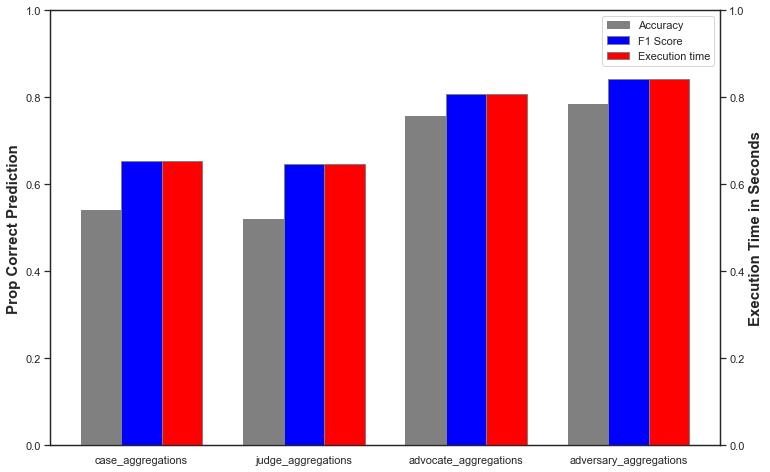

In [75]:
disp_accuracy(acc, labs=list(acc["dataset"]))

### Confusion Matrices
#### Logistic Regression Model - All Utterances

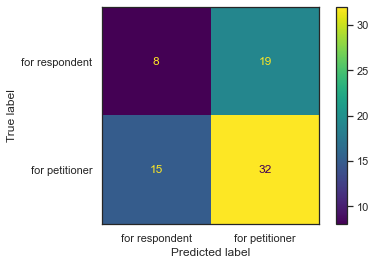

In [76]:
disp_conf_matrix(lr.confusion_matrix["case_aggregations"])

#### Logistic Regression Model - Judge Utterances

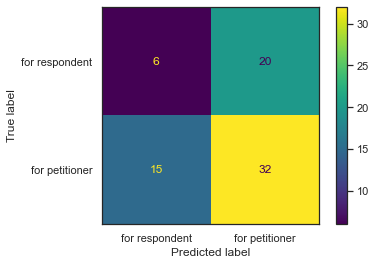

In [77]:
disp_conf_matrix(lr.confusion_matrix["judge_aggregations"])

#### Logistic Regression Model - Advocate Utterances

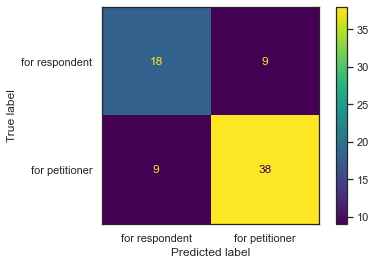

In [78]:
disp_conf_matrix(lr.confusion_matrix["advocate_aggregations"])

#### Logistic Regression Model - Adversary Utterances

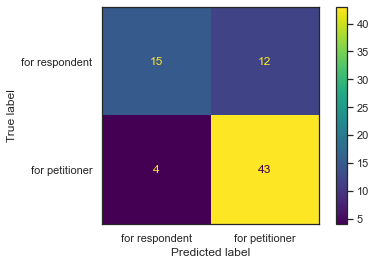

In [79]:
disp_conf_matrix(lr.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

In [80]:
# Array of values for tuning
max_feature_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
max_iter_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

#### Max Features Finetuning

In [81]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_feature_value in max_feature_values:
    lr_model = LogisticRegression(
        debug_mode=False, max_features=max_feature_value
    )
    lr_model.run()

    accuracy_dicts.append(lr_model.accuracies)
    f1_dicts.append(lr_model.f1)

print("Done parameter finetuning for max features")

max_feature_lr_melted, max_feature_f1_lr_melted, et_df = get_long_df(
    "Max Features",
    max_feature_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for max features


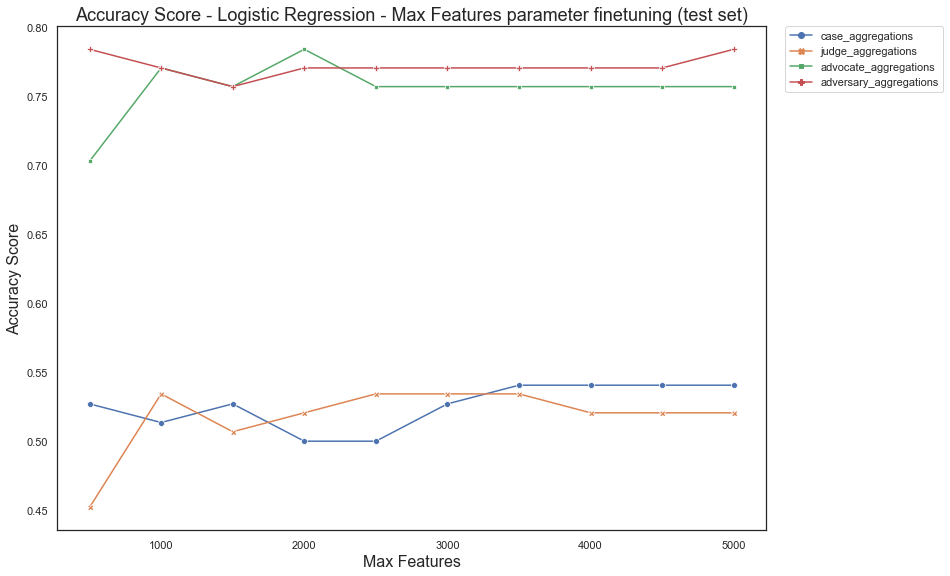

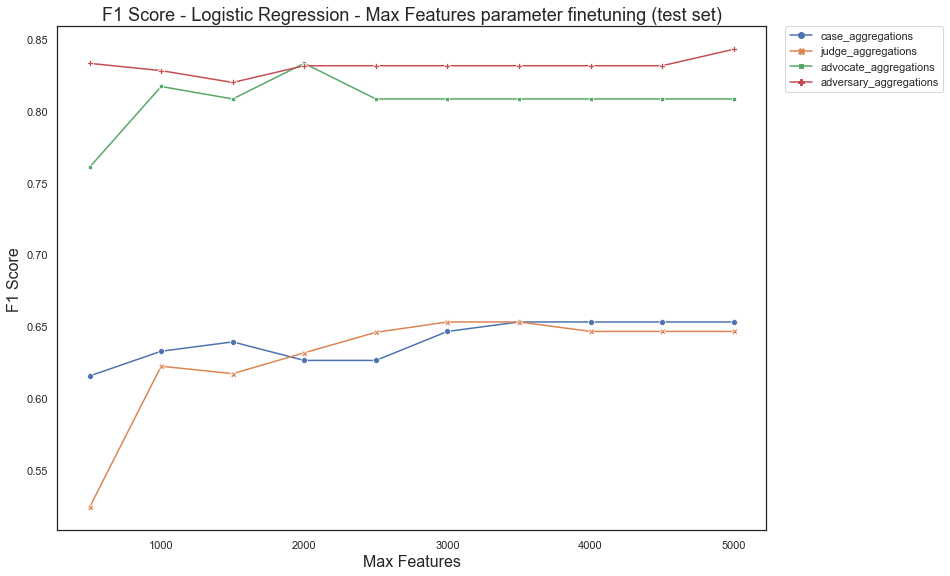

In [82]:
plot_accuracy_scores(
    max_feature_lr_melted, "Max Features", "Logistic Regression"
)
plot_accuracy_scores(
    max_feature_f1_lr_melted,
    "Max Features",
    "Logistic Regression",
    accuracy_metric="F1",
)

#### Maximum Number of Iterations Finetuning

In [83]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_iter_value in max_iter_values:
    lr_model = LogisticRegression(debug_mode=False, max_iter=max_iter_value)
    lr_model.run()

    accuracy_dicts.append(lr_model.accuracies)
    f1_dicts.append(lr_model.f1)

print("Done parameter finetuning for max iterations")

max_iter_melted, max_iter_f1_melted, et_df = get_long_df(
    "Max Iterations",
    max_iter_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for max iterations


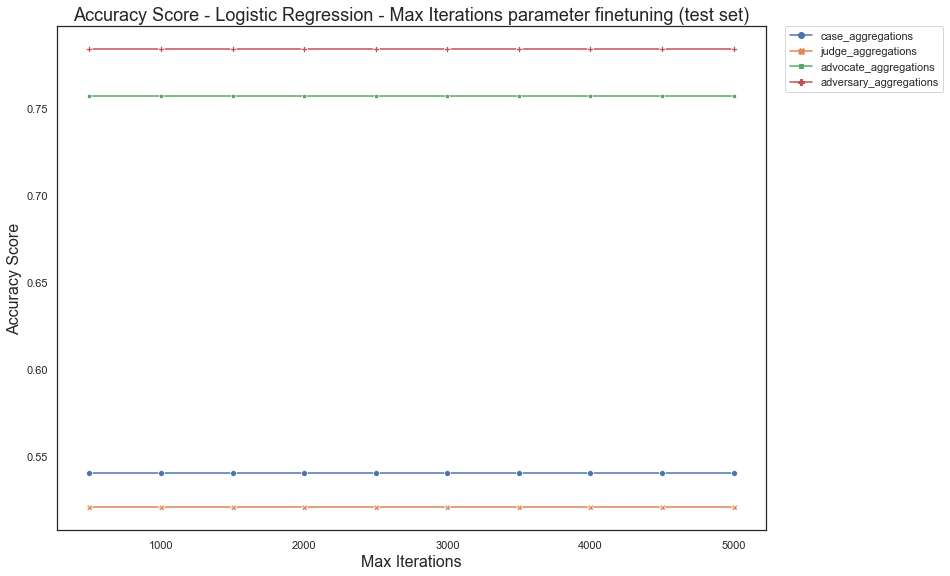

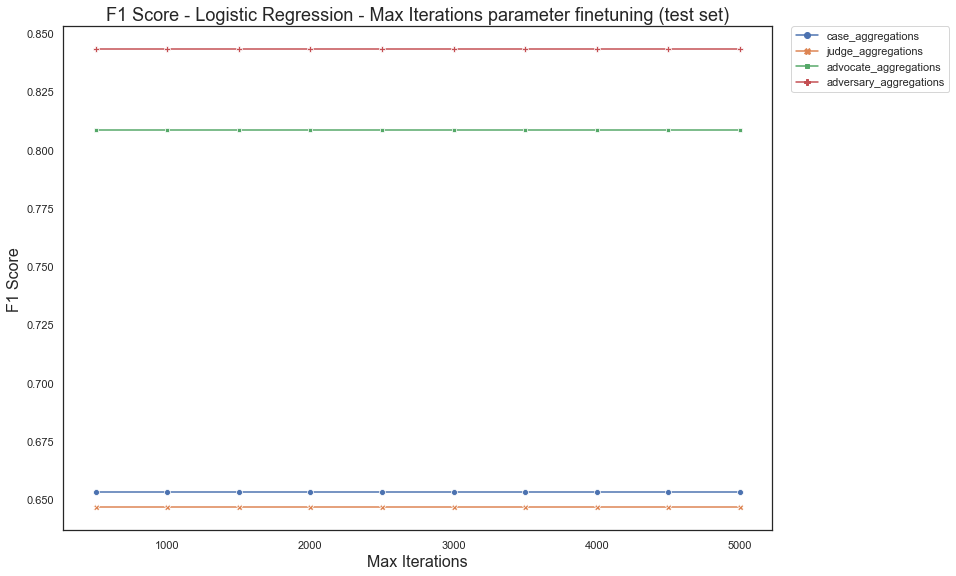

In [84]:
plot_accuracy_scores(max_iter_melted, "Max Iterations", "Logistic Regression")
plot_accuracy_scores(
    max_iter_f1_melted,
    "Max Iterations",
    "Logistic Regression",
    accuracy_metric="F1",
)

## Random Forest
### Default Parameters

- **Maximum Depth**: None
- **Maximum Features**: 5000
- **Number of trees**: 100
- **Test Size**: 0.20

### Accuracies and F1 Score

In [85]:
acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    rf.accuracies,
    rf.f1,
    rf.execution_times,
)
acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.621622,0.762712,0.762712
1,judge_aggregations,0.643836,0.783333,0.783333
2,advocate_aggregations,0.797297,0.857143,0.857143
3,adversary_aggregations,0.810811,0.857143,0.857143


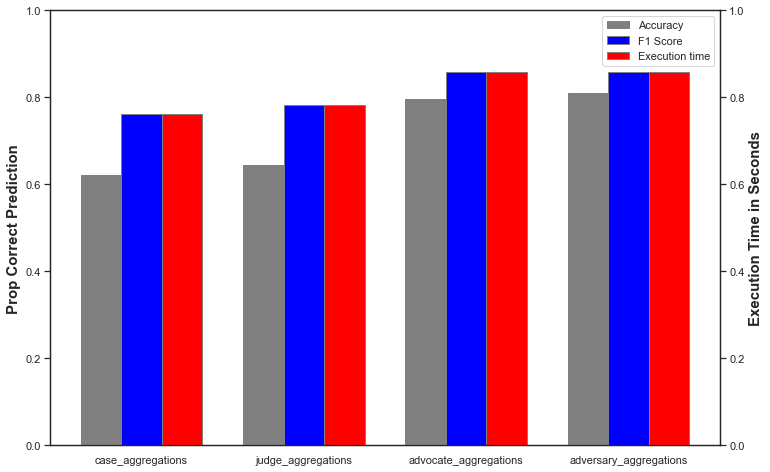

In [86]:
disp_accuracy(acc, labs=acc["dataset"])

### Confusion Matrices
#### Random Forest Model - All Utterances

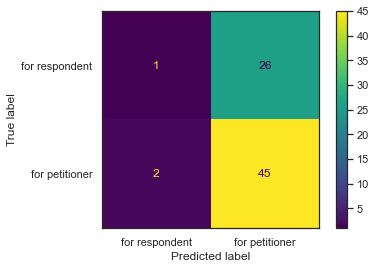

In [87]:
disp_conf_matrix(rf.confusion_matrix["case_aggregations"])

#### Random Forest Model - Judge Utterances

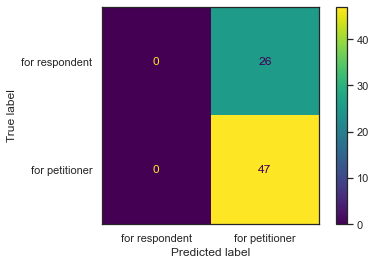

In [88]:
disp_conf_matrix(rf.confusion_matrix["judge_aggregations"])

#### Random Forest Model - Advocate Utterances

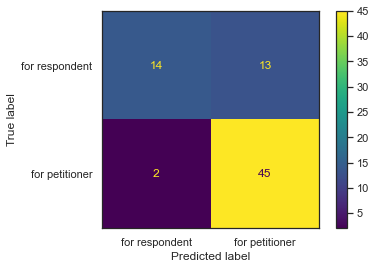

In [89]:
disp_conf_matrix(rf.confusion_matrix["advocate_aggregations"])

#### Random Forest Model - Adversary Utterances

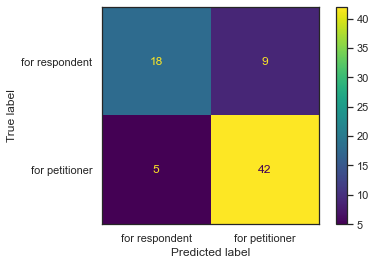

In [90]:
disp_conf_matrix(rf.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

In [91]:
# Create an array of different values to test
max_feature_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_trees_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Max Features Finetuning

In [92]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_feature_value in max_feature_values:
    rf_model = RandomForest(debug_mode=False, max_features=max_feature_value)
    rf_model.run()

    accuracy_dicts.append(rf_model.accuracies)
    f1_dicts.append(rf_model.f1)

print("Done parameter finetuning for max features")

max_feature_melted, max_feature_f1_melted, et_df = get_long_df(
    "Max Features",
    max_feature_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for max features


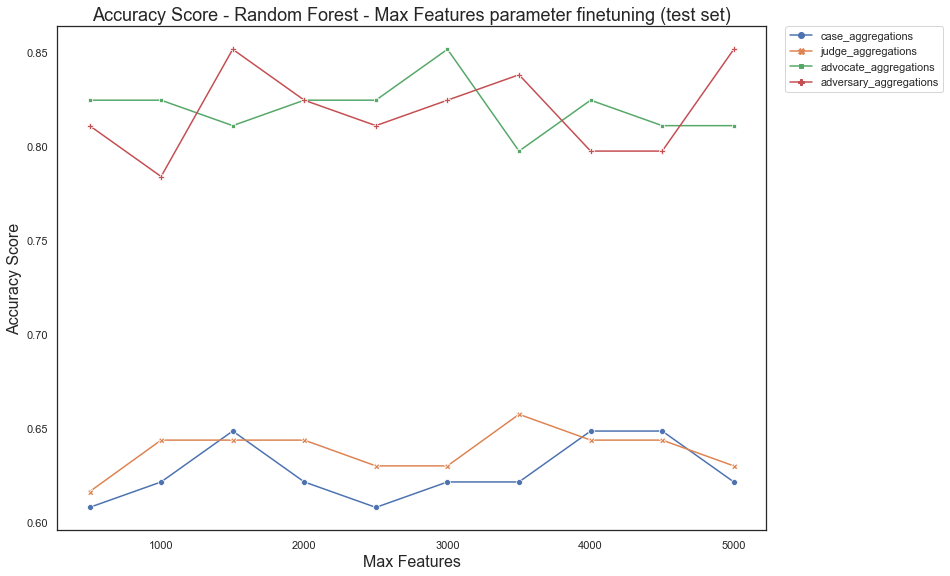

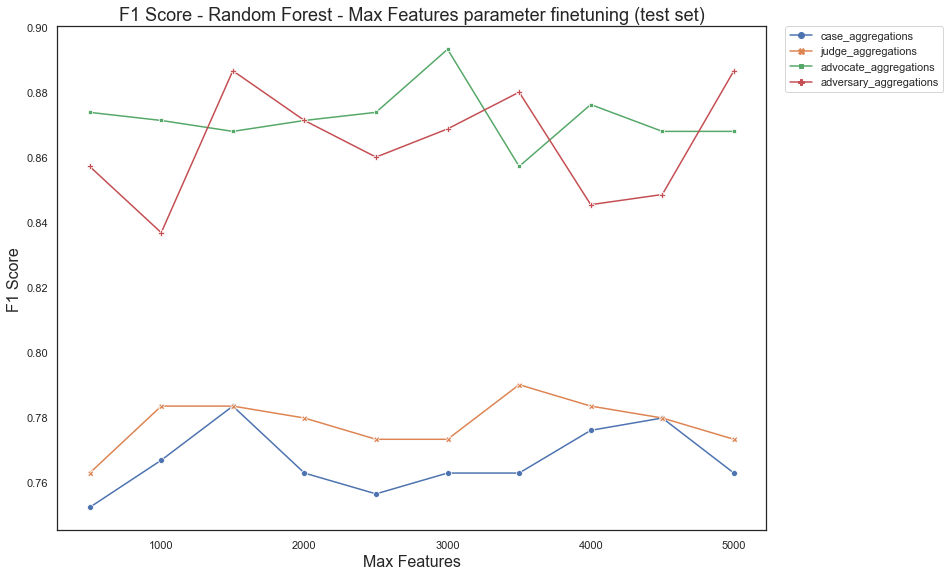

In [93]:
plot_accuracy_scores(max_feature_melted, "Max Features", "Random Forest")
plot_accuracy_scores(
    max_feature_f1_melted, "Max Features", "Random Forest", accuracy_metric="F1"
)

#### Number of Trees Finetuning

In [94]:
# Do number of trees finetuning
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for num_tree_value in num_trees_values:
    rf_model = RandomForest(debug_mode=False, num_trees=num_tree_value)
    rf_model.run()

    accuracy_dicts.append(rf_model.accuracies)
    f1_dicts.append(rf_model.f1)

print("Done parameter finetuning for number of trees")

num_trees_melted, num_trees_f1_melted, et_df = get_long_df(
    "Number of Trees",
    num_trees_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for number of trees


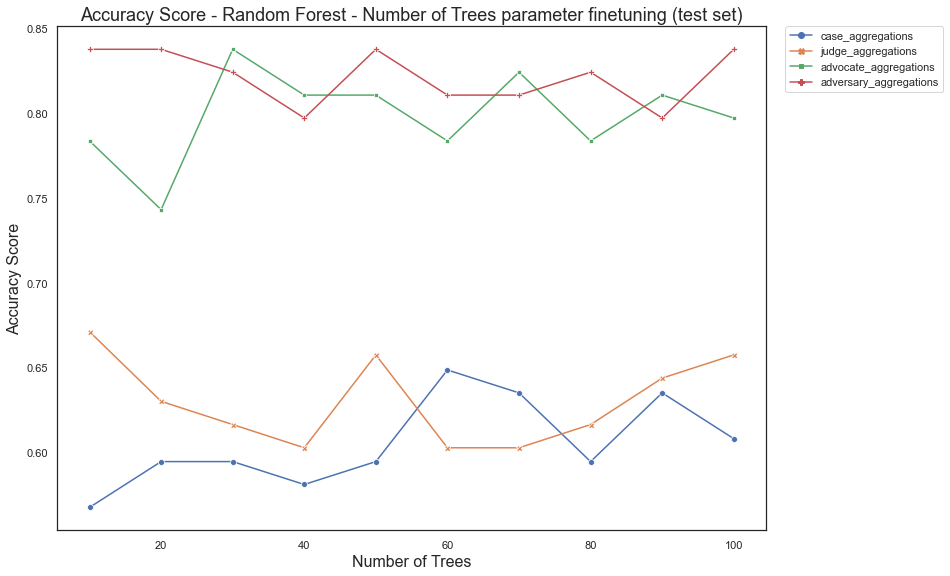

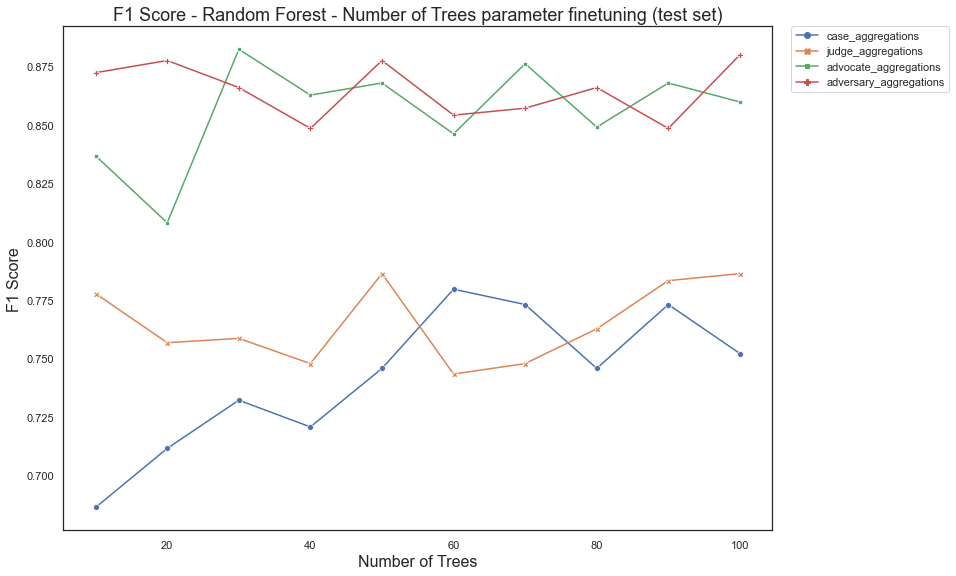

In [95]:
plot_accuracy_scores(num_trees_melted, "Number of Trees", "Random Forest")
plot_accuracy_scores(
    num_trees_f1_melted,
    "Number of Trees",
    "Random Forest",
    accuracy_metric="F1",
)

#### Max Depth Finetuning

In [96]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_depth_value in max_depth_values:
    xgboost_model = RandomForest(debug_mode=False, max_depth=max_depth_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done parameter finetuning for max_depth")

max_depth_rf_melted, max_depth_f1_rf_melted, et_df = get_long_df(
    "Max Tree Depth",
    max_depth_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for max_depth


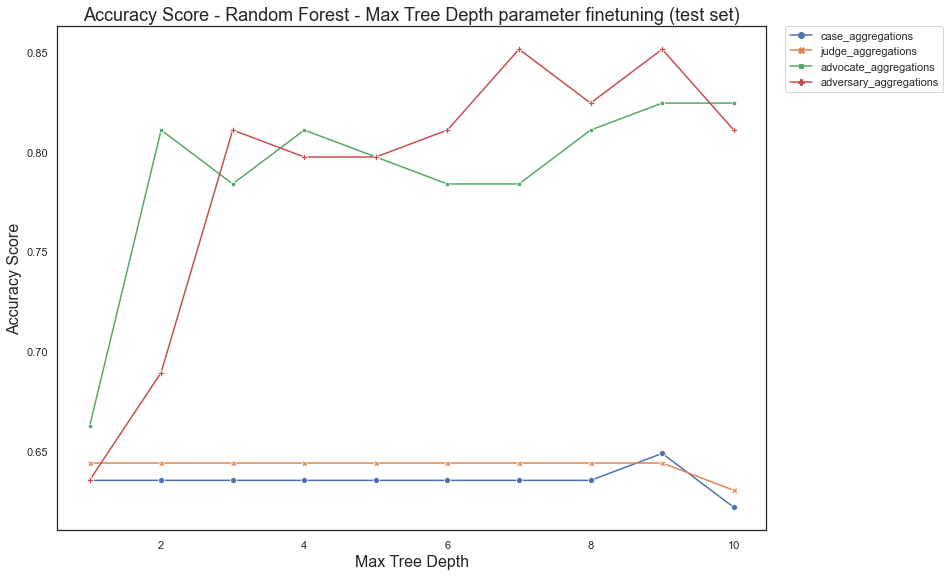

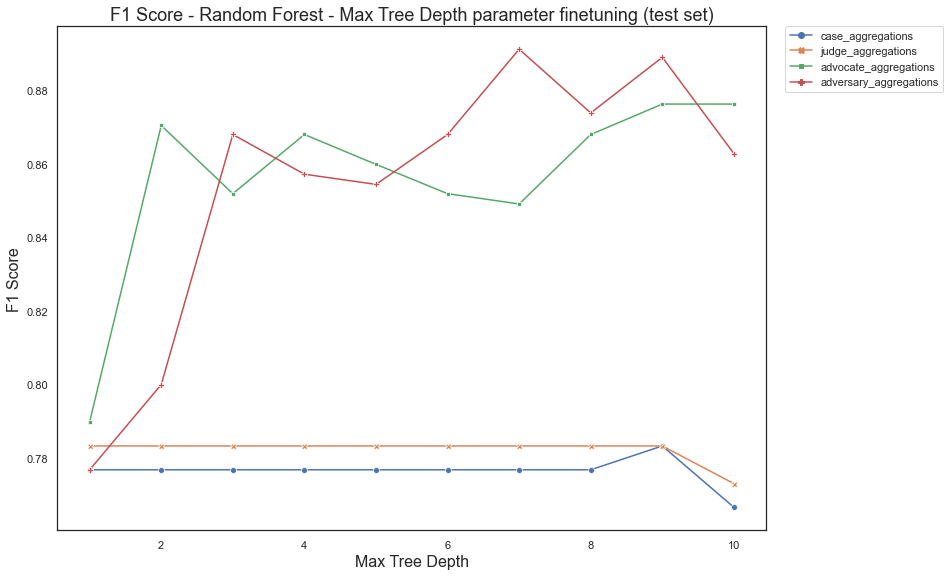

In [97]:
plot_accuracy_scores(max_depth_rf_melted, "Max Tree Depth", "Random Forest")
plot_accuracy_scores(
    max_depth_f1_rf_melted,
    "Max Tree Depth",
    "Random Forest",
    accuracy_metric="F1",
)

## Gradient Boosted Tree
### Default Parameters

- **Maximum number of features**: 5000
- **Test size**: 0.20
- **Maximum depth**: 7
- **Number of estimators**: 100
- **Learning rate**: 0.3
- **Subsample**: 1

### Accuracies and F1 Score

In [98]:
acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    xg.accuracies,
    xg.f1,
    xg.execution_times,
)
acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.567568,0.680000,0.680000
1,judge_aggregations,0.547945,0.697248,0.697248
2,advocate_aggregations,0.810811,0.860000,0.860000
3,adversary_aggregations,0.824324,0.863158,0.863158


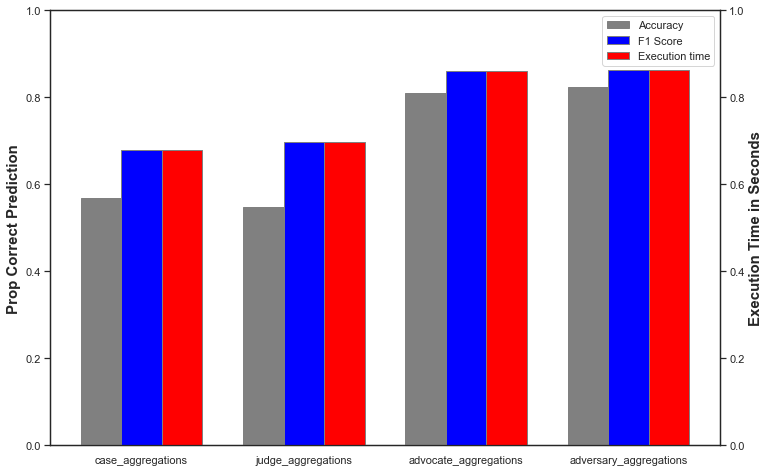

In [99]:
disp_accuracy(acc, labs=acc["dataset"])

### Confusion Matrices
#### Gradient Boosted Tree Model - All Utterances

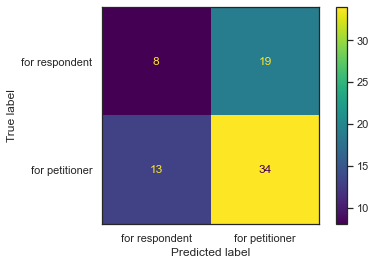

In [100]:
disp_conf_matrix(xg.confusion_matrix["case_aggregations"])

#### Gradient Boosted Tree Model - Judge Utterances

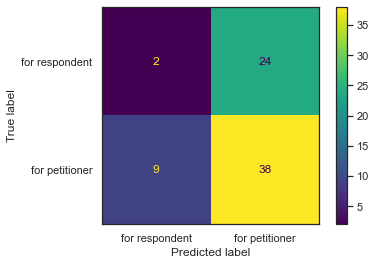

In [101]:
disp_conf_matrix(xg.confusion_matrix["judge_aggregations"])

#### Gradient Boosted Tree Model - Advocate Utterances

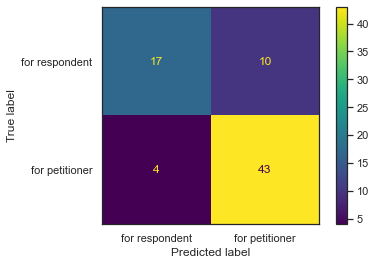

In [102]:
disp_conf_matrix(xg.confusion_matrix["advocate_aggregations"])

#### Gradient Boosted Tree Model - Adversary Utterances

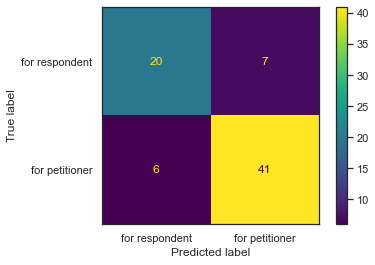

In [103]:
disp_conf_matrix(xg.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

In [104]:
# Create an array of different values to test
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
subsample_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Eta (Learning Rate) Finetuning

In [105]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for eta_value in eta_values:
    xgboost_model = XGBoost(debug_mode=False, eta=eta_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done parameter finetuning for eta")

eta_melted, eta_f1_melted, et_df = get_long_df(
    "eta", eta_values, accuracy_dicts, f1_dicts, execution_time_dicts=None
)

Done parameter finetuning for eta


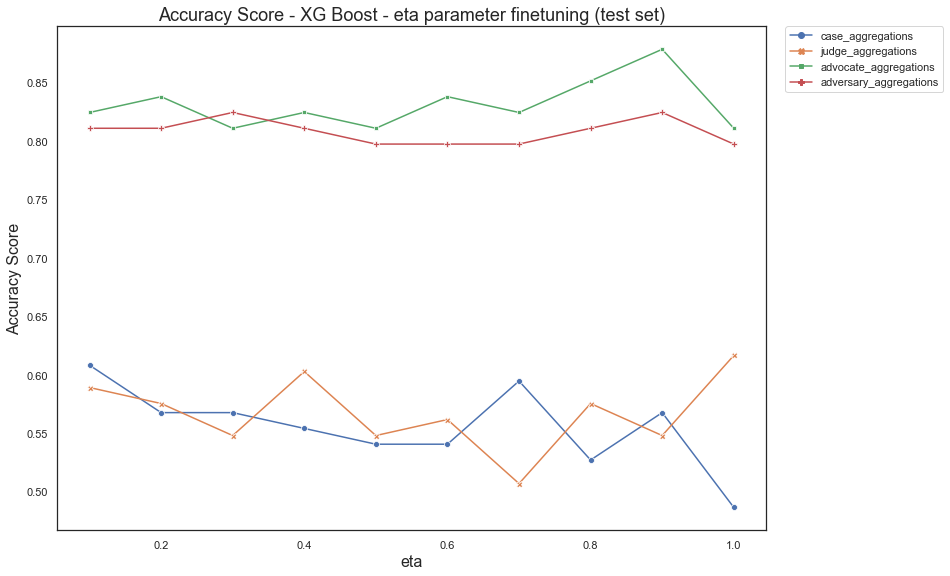

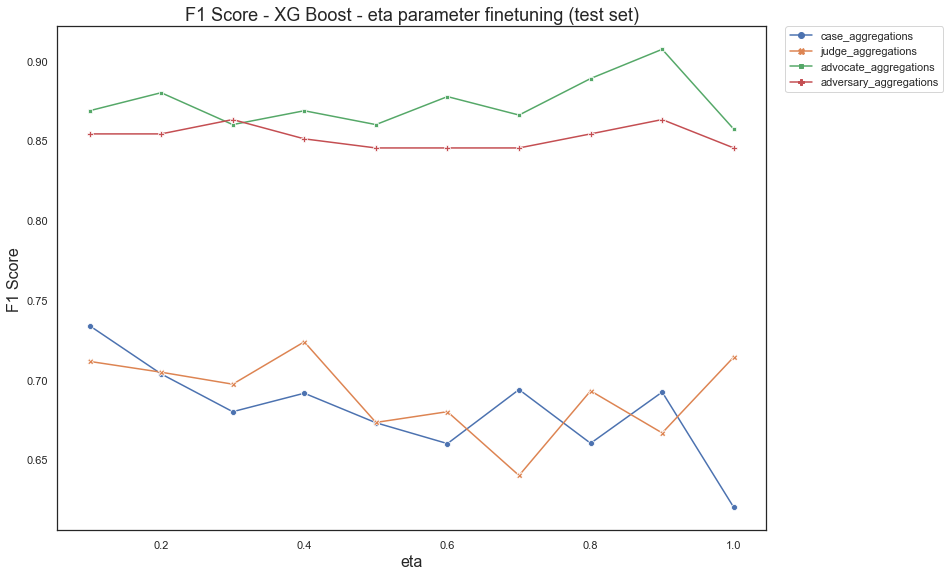

In [106]:
plot_accuracy_scores(eta_melted, "eta", "XG Boost")
plot_accuracy_scores(eta_f1_melted, "eta", "XG Boost", accuracy_metric="F1")

#### Maximum Tree Depth Finetuning

In [107]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_depth_value in max_depth_values:
    xgboost_model = XGBoost(debug_mode=False, max_depth=max_depth_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done parameter finetuning for max_depth")

max_depth_melted, max_depth_f1_melted, et_df = get_long_df(
    "Max Tree Depth",
    max_depth_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done parameter finetuning for max_depth


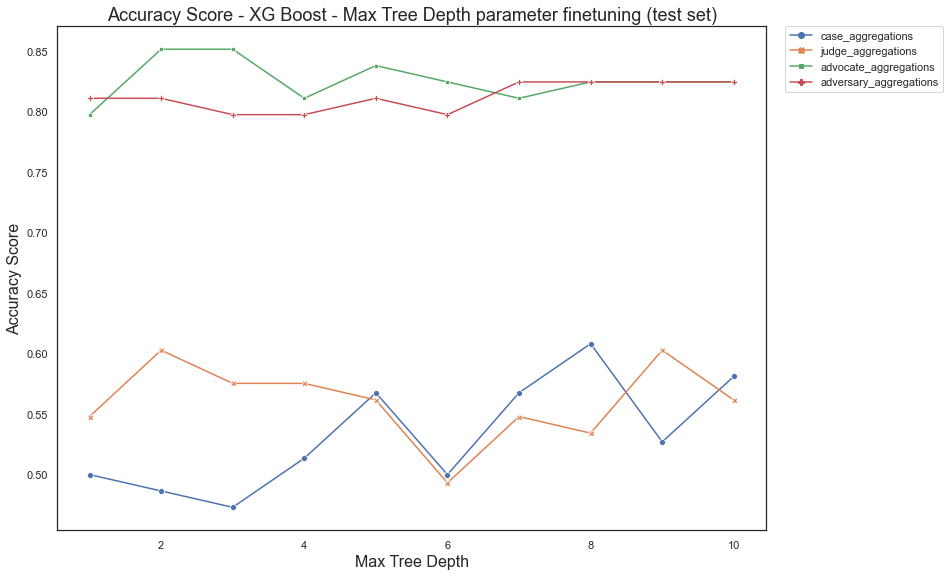

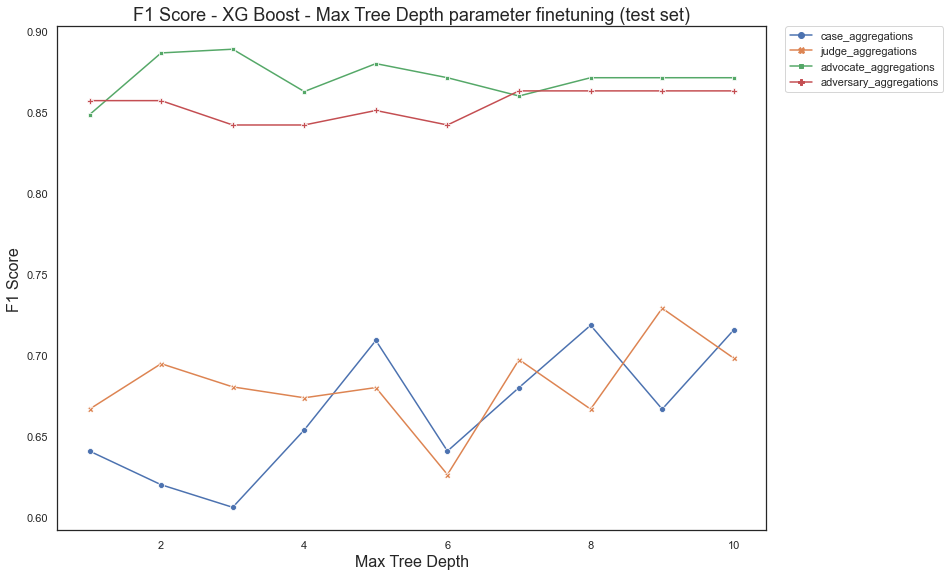

In [108]:
plot_accuracy_scores(max_depth_melted, "Max Tree Depth", "XG Boost")
plot_accuracy_scores(
    max_depth_f1_melted, "Max Tree Depth", "XG Boost", accuracy_metric="F1"
)

#### Subsample Finetuning

In [109]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for subsample_value in subsample_values:
    xgboost_model = XGBoost(debug_mode=False, subsample=subsample_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done with subsample finetuning")

subsample_melted, subsample_f1_melted, et_df = get_long_df(
    "Subsample Value",
    subsample_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=None,
)

Done with subsample finetuning


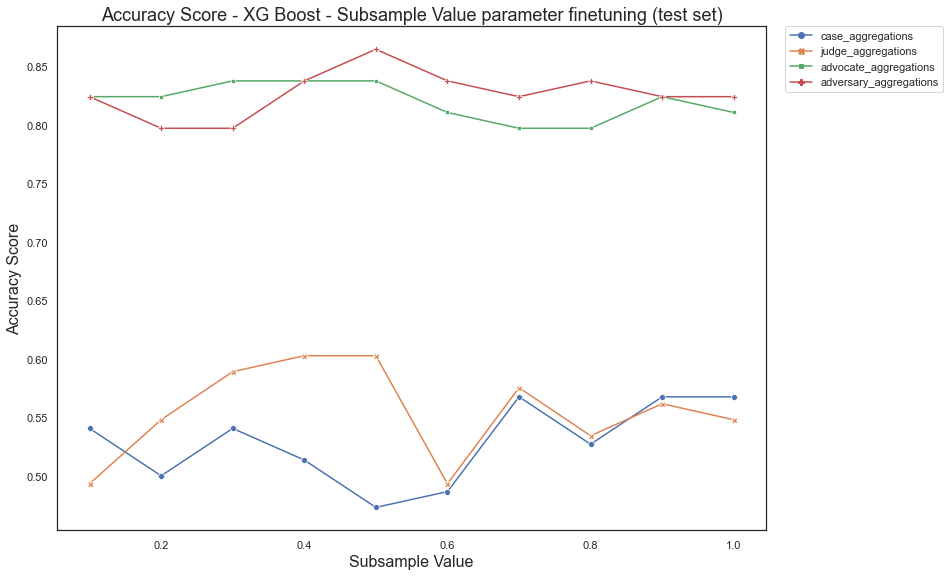

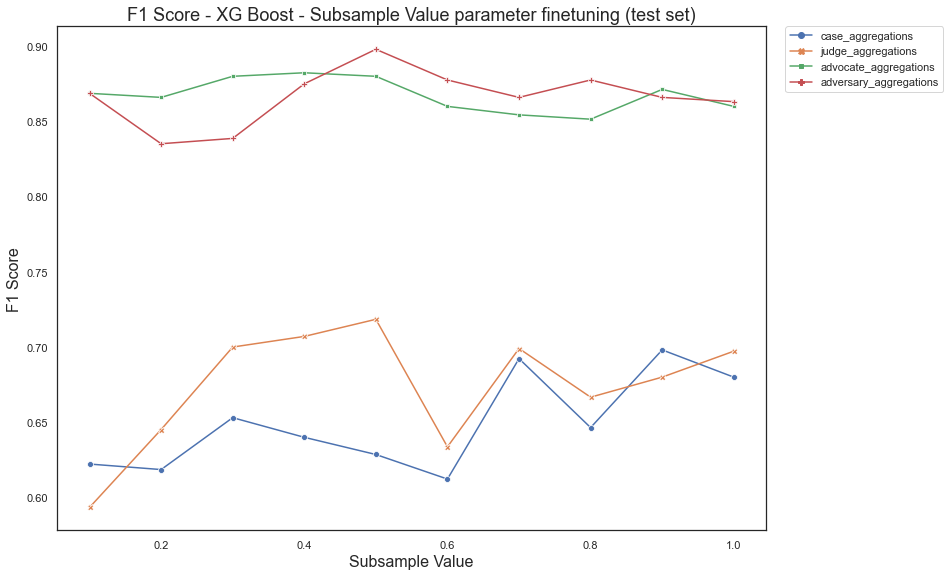

In [110]:
# Plot accuracy scores
plot_accuracy_scores(subsample_melted, "Subsample Value", "XG Boost")
plot_accuracy_scores(
    subsample_f1_melted, "Subsample Value", "XG Boost", accuracy_metric="F1"
)

## Model Comparisons
Using the advocate utterances dataframe as a case study

In [111]:
model_comp

,model,accuracy,f1_score,execution_time
0,logistic regression,0.783784,0.843137,1.188105
1,random forest,0.810811,0.857143,0.748561
2,xg boost,0.824324,0.863158,3.061237


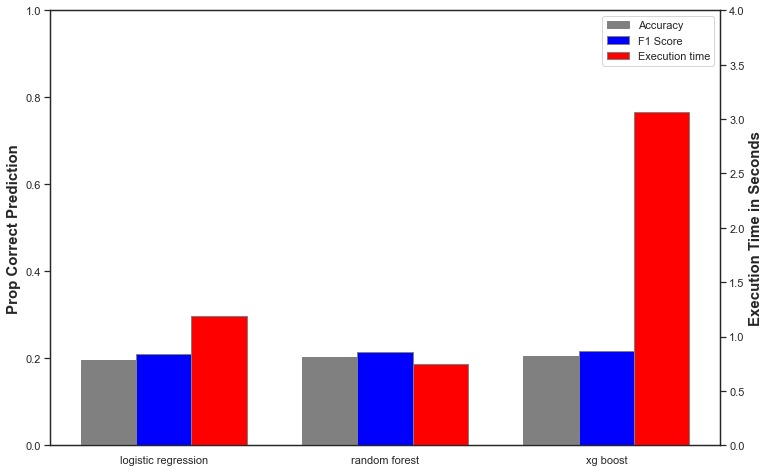

In [112]:
disp_accuracy(model_comp, labs=model_comp["model"], x_label="Model")

## Final Thoughts and Applications

<span style="color:red"><b>[insert]</b></span>

## Thank you!
### Any Questions?